In [3]:
import sqlite3
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

In [4]:
con = duckdb.connect('supercell.duckdb')

In [5]:
query = """
select * from total_cost ;
"""

df = con.execute(query).fetchdf()
print(df)

         month  total_cost   instance_type    product          region  \
0   2024-01-01    3434.274      c5.8xlarge  AmazonEC2  ap-southeast-1   
1   2024-01-01    3301.899      c5.8xlarge  AmazonEC2    eu-central-1   
2   2024-01-01   24044.550      c5.8xlarge  AmazonEC2       us-east-1   
3   2024-01-01    3509.294      c5.8xlarge  AmazonEC2       us-west-1   
4   2024-01-01    6781.690     c7g.8xlarge  AmazonEC2  ap-southeast-1   
..         ...         ...             ...        ...             ...   
150 2024-08-01    2507.300  db.r7g.4xlarge  AmazonRDS  ap-southeast-1   
151 2024-08-01      14.953      m4.4xlarge  AmazonEC2  ap-southeast-1   
152 2024-08-01     103.873      m4.4xlarge  AmazonEC2       us-east-1   
153 2024-08-01       9.353     m6i.4xlarge  AmazonEC2    eu-central-1   
154 2024-08-01       3.746     m6i.4xlarge  AmazonEC2       us-east-1   

         pricing_model tag_keys tag_values  
0             OnDemand     Game  BoomBeach  
1             OnDemand     Game  

## Insights charts from the cubes

## What is total cost trend ?

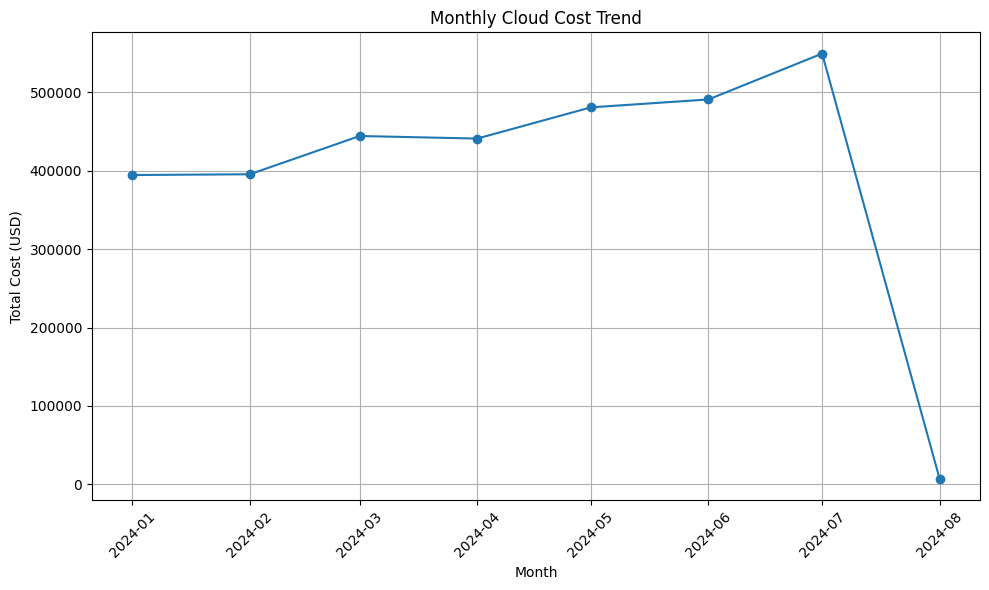

In [6]:

## What is total cost trend ?
query = """
    SELECT
        month,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1
    ORDER BY 1
"""

# Load into a DataFrame
df = con.execute(query).fetchdf()

# Plotting
plt.figure(figsize=(10, 6))
plt.ticklabel_format(axis='y', style='plain')
plt.plot(df['month'], df['monthly_cost'], marker='o')
plt.title('Monthly Cloud Cost Trend')
plt.xlabel('Month')
plt.ylabel('Total Cost (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## What is total cost trend ,by region by month ?

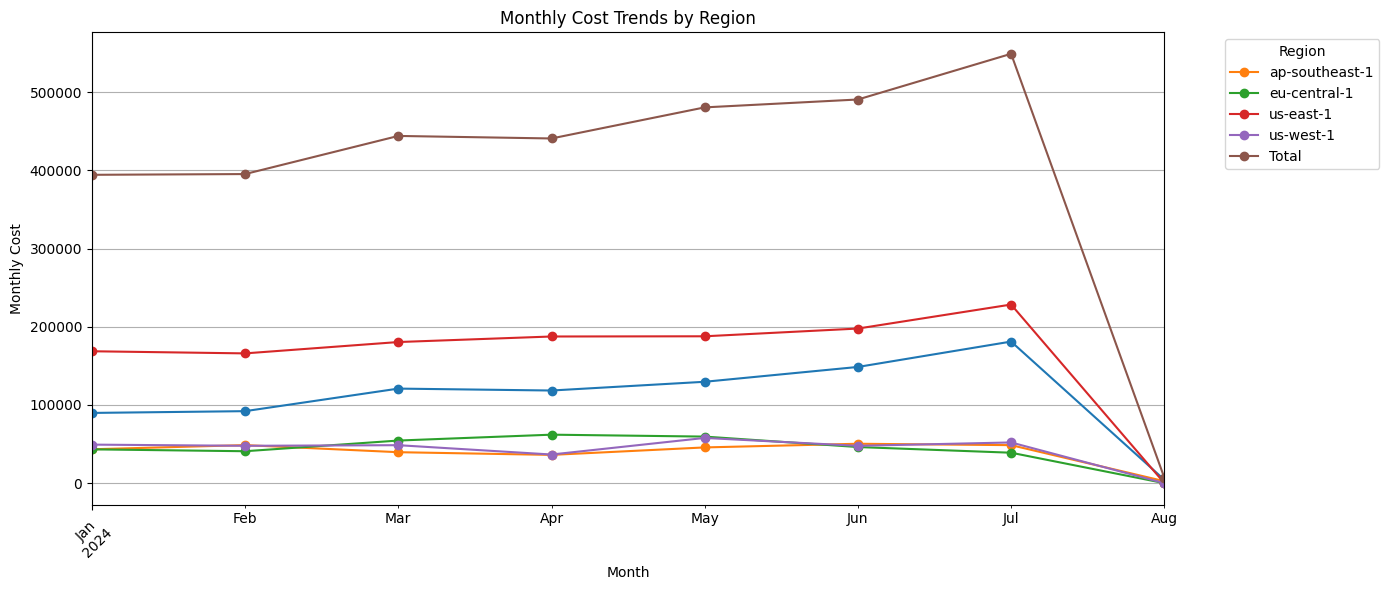

In [7]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Query DuckDB for cost data by month and region
query = """
    SELECT
        month,
        region,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1, 2
    ORDER BY 1, 2
"""


df = con.execute(query).fetchdf()

# Ensure 'month' is a datetime type for correct plotting
df['month'] = pd.to_datetime(df['month'])

# Pivot data to wide format (columns = regions, index = month)
pivot_df = df.pivot(index='month', columns='region', values='monthly_cost')

# Optional: add total line across all regions
pivot_df['Total'] = pivot_df.sum(axis=1)

# Plot all trend lines
ax = pivot_df.plot(figsize=(14, 6), marker='o')

plt.title("Monthly Cost Trends by Region")
plt.xlabel("Month")
plt.ylabel("Monthly Cost")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## What is total cost trend ,by pricing model by month ?

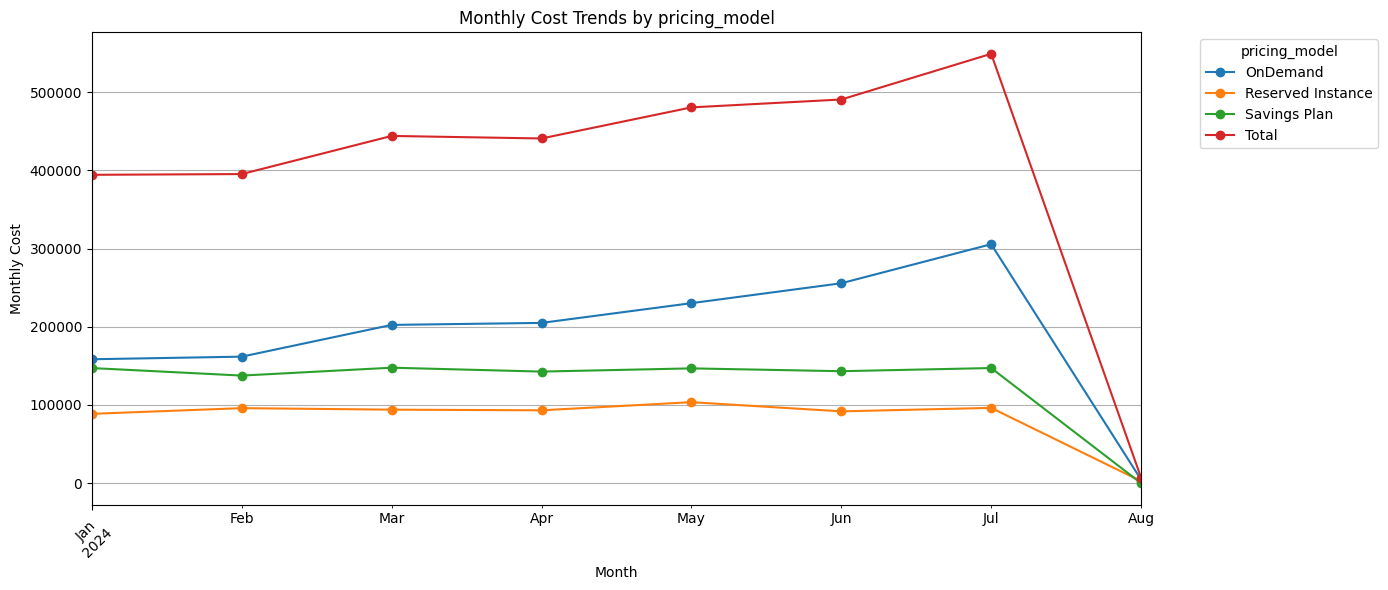

In [8]:

## What is total cost trend ,by pricing model by month ?
query = """
    SELECT
        month,
        pricing_model,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1,2
    ORDER BY 1,2
"""

# Load into a DataFrame
df = con.execute(query).fetchdf()
# Ensure 'month' is a datetime type for correct plotting
df['month'] = pd.to_datetime(df['month'])

# Pivot data to wide format (columns = regions, index = month)
pivot_df = df.pivot(index='month', columns='pricing_model', values='monthly_cost')

# Optional: add total line across all regions
pivot_df['Total'] = pivot_df.sum(axis=1)

# Plot all trend lines
ax = pivot_df.plot(figsize=(14, 6), marker='o')

plt.title("Monthly Cost Trends by pricing_model")
plt.xlabel("Month")
plt.ylabel("Monthly Cost")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="pricing_model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

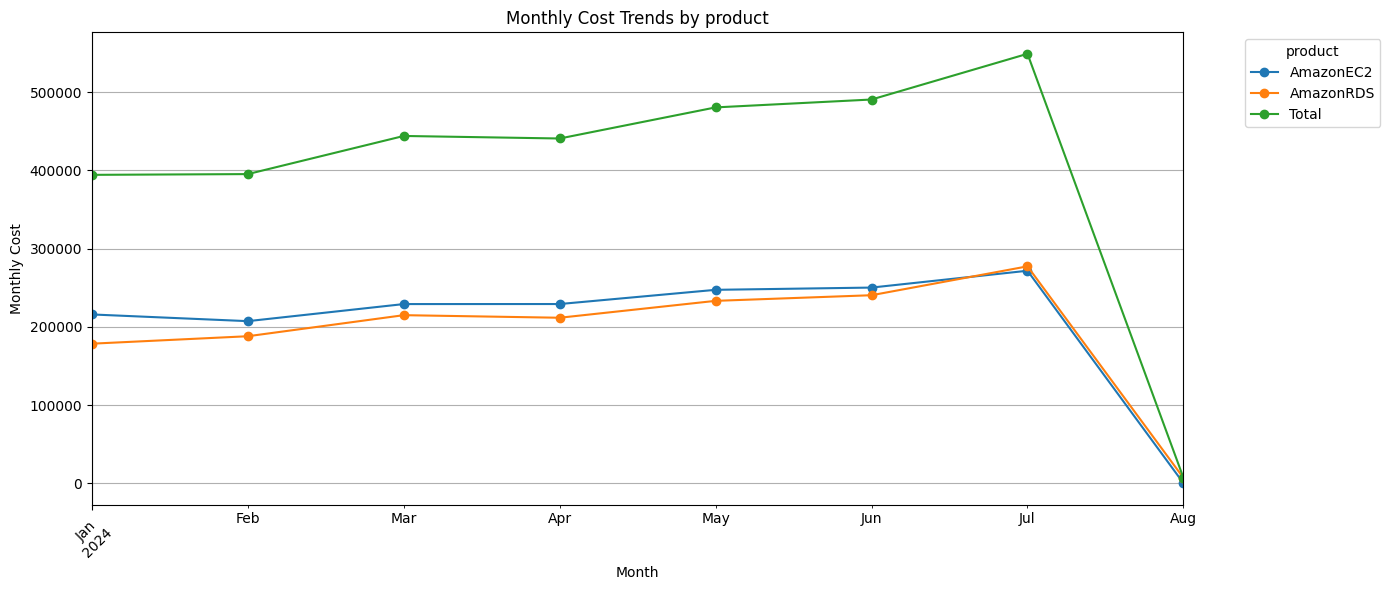

In [9]:

## What is total cost trend ,by service_code by month ?
query = """
    SELECT
        month,
        product,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1,2
    ORDER BY 1,2
"""

# Load into a DataFrame
df = con.execute(query).fetchdf()
# Ensure 'month' is a datetime type for correct plotting
df['month'] = pd.to_datetime(df['month'])

# Pivot data to wide format (columns = regions, index = month)
pivot_df = df.pivot(index='month', columns='product', values='monthly_cost')

# Optional: add total line across all regions
pivot_df['Total'] = pivot_df.sum(axis=1)

# Plot all trend lines
ax = pivot_df.plot(figsize=(14, 6), marker='o')

plt.title("Monthly Cost Trends by product")
plt.xlabel("Month")
plt.ylabel("Monthly Cost")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

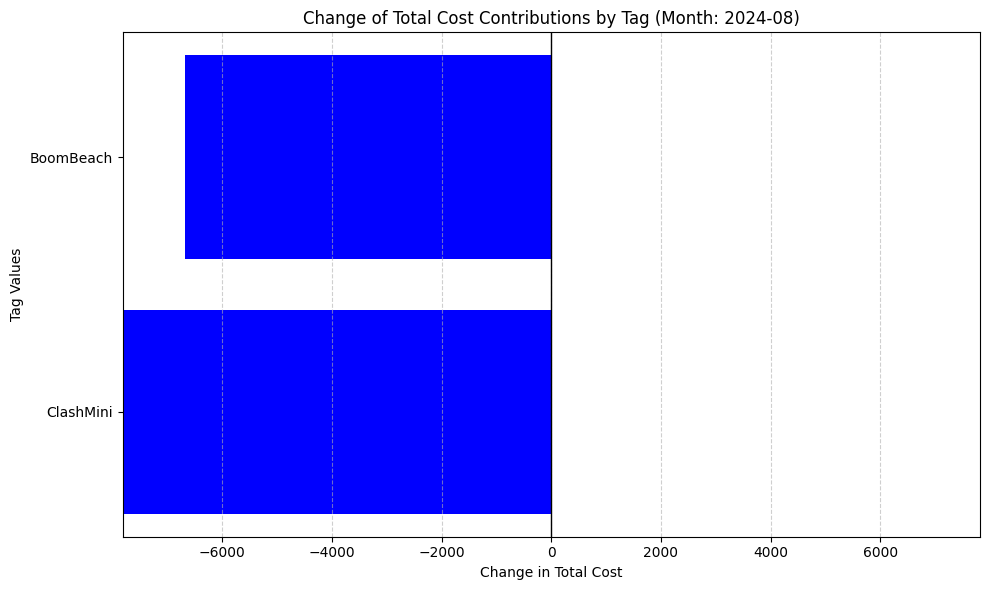

In [10]:
query = """
    with base as (
        SELECT 
            total_cost - lag(total_cost) OVER (PARTITION BY tag_values ORDER BY month) as delta,
            * 
        FROM total_cost
    ),
    
    max_month as (
        SELECT max(month) as month FROM base
    )
    
    SELECT
        SUM(base.delta) as change_of_total_cost,
        base.month, 
        base.tag_values
    FROM base 
    INNER JOIN max_month ON base.month = max_month.month
    GROUP BY base.month, base.tag_values;
"""


df = con.execute(query).fetchdf()
df.head()

# Sort by value to make plot more readable
df_sorted = df.sort_values(by="change_of_total_cost")
max_val = abs(df_sorted['change_of_total_cost']).max()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    df_sorted['tag_values'],
    df_sorted['change_of_total_cost'],
    color=['green' if x >= 0 else 'blue' for x in df_sorted['change_of_total_cost']]
)

# Centralize axis
plt.axvline(0, color='black', linewidth=1)
plt.xlim(-max_val, max_val)  # Set symmetric x-axis

# Titles and labels
plt.title(f"Change of Total Cost Contributions by Tag (Month: {df_sorted['month'].iloc[0].strftime('%Y-%m')})")
plt.xlabel("Change in Total Cost")
plt.ylabel("Tag Values")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

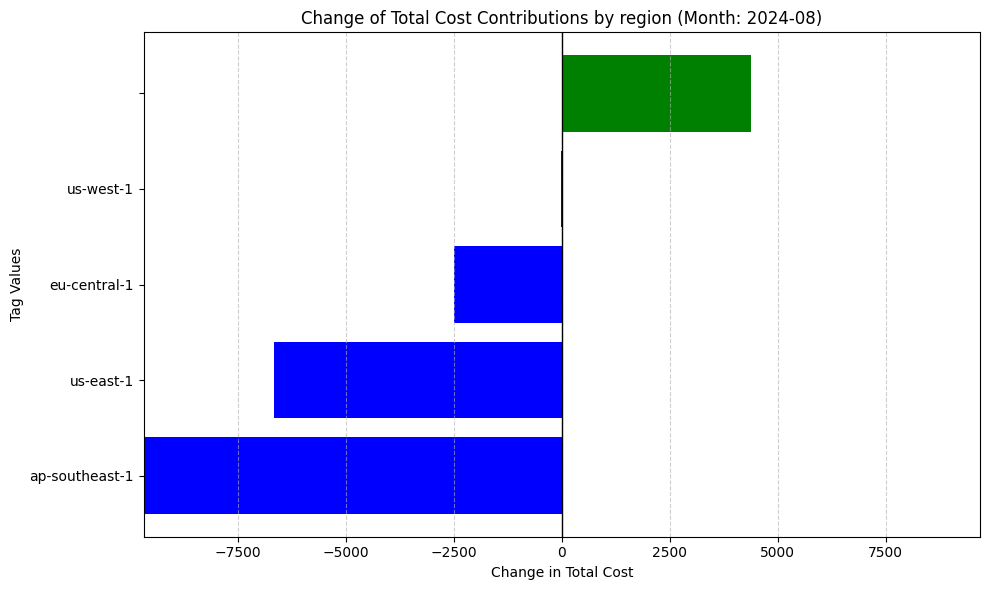

In [11]:
query = """
    with base as (
        SELECT 
            total_cost - lag(total_cost) OVER (PARTITION BY tag_values ORDER BY month) as delta,
            * 
        FROM total_cost
    ),
    
    max_month as (
        SELECT max(month) as month FROM base
    )
    
    SELECT
        SUM(base.delta) as change_of_total_cost,
        base.month, 
        base.region
    FROM base 
    INNER JOIN max_month ON base.month = max_month.month
    GROUP BY base.month, base.region;
"""


df = con.execute(query).fetchdf()
df.head()

# Sort by value to make plot more readable
df_sorted = df.sort_values(by="change_of_total_cost")
max_val = abs(df_sorted['change_of_total_cost']).max()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    df_sorted['region'],
    df_sorted['change_of_total_cost'],
    color=['green' if x >= 0 else 'blue' for x in df_sorted['change_of_total_cost']]
)

# Centralize axis
plt.axvline(0, color='black', linewidth=1)
plt.xlim(-max_val, max_val)  # Set symmetric x-axis

# Titles and labels
plt.title(f"Change of Total Cost Contributions by region (Month: {df_sorted['month'].iloc[0].strftime('%Y-%m')})")
plt.xlabel("Change in Total Cost")
plt.ylabel("Tag Values")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()